<a href="https://colab.research.google.com/github/JINYUHOON/VIS_temp/blob/main/11_Train_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow import keras
from tensorflow.keras import losses

In [3]:
from albumentations.augmentations.transforms import ShiftScaleRotate
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode =='train':
            self.transform = A.Compose([
                                   A.HorizontalFlip(p=0.5),
                                   A.ShiftScaleRotate(
                                       p = 0.5,
                                       shift_limit = 0.05,
                                       scale_limit = 0.05,
                                       rotate_limit = 15,
                                   ),
                                #    A.CoarseDropout(
                                #        p=0.5,
                                #        max_holes = 8,
                                #        max_height = int( 0.1 * size),
                                #        max_width = int( 0.1 * size)    
                                #    ),
                                   A.RandomBrightnessContrast(p=0.2),
            ])
    

    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask

In [4]:
def iou(y_true, y_pred):
    
    smooth = 1.
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    score = intersection / (union + smooth)

    return score



def dice_coef(y_true, y_pred):

    smooth = 1.
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return score



def dice_loss(y_true, y_pred):

    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred): # binary_crossentropy

    loss = (1. * losses.binary_crossentropy(y_true, y_pred)) + (1. * dice_loss(y_true, y_pred))

    return loss

In [5]:
base_path = '/content/drive/MyDrive/HOON/exam/OX/data/'
import math

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.mode = mode
        self.image_size = image_size
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]

        # Remove invalid
        invalid_filenames = [
                             'Egyptian_Mau_14',
                             'Egyptian_Mau_139',
                             'Egyptian_Mau_145',
                             'Egyptian_Mau_156',
                             'Egyptian_Mau_167',
                             'Egyptian_Mau_177',
                             'Egyptian_Mau_186',
                             'Egyptian_Mau_1191',
                             'Abyssinian_5',
                             'Abyssinian_34',
                             'chihuahua_121',
                             'beagle_116'
                             
        ]

        self.df = self.df[-self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size , mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for _ , r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(base_path + f'images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (self.image_size , self.image_size))

            mask = cv2.imread(base_path + f'annotations/trimaps/{file_name}.png', cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size , self.image_size))
            mask[mask != 1] = 0


            if self.mode == 'train':
                # image = image.astype('uint8')
                image , mask= self.transform(image=image,
                                       mask=mask)
                

            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')
            

            batch_x.append(image)
            batch_y.append(mask)

        return batch_x, batch_y

    def on_epoch_end(self):

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

csv_path = base_path + 'kfolds.csv'

train_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 128,
                                mode='train', 
                                shuffle=True)

valid_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 128,
                                mode='val', 
                                shuffle=True)

In [6]:
!pip install keras_unet

In [7]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape = (128,128, 3),
    use_batch_norm=True,
    upsample_mode='deconv',
    num_classes=1,
    dropout_type='spatial',
    use_attention=True,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid')

model.compile(optimizer = 'adam', loss = bce_dice_loss, metrics=[iou])
# model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Tensorboard

In [12]:
from tensorflow.keras.callbacks import TensorBoard

callbacks = [
             TensorBoard('weights/')
]

In [ ]:
from tensorflow.keras.callbacks import Callbacks

class TrainHistory(Callbacks):
    def __init__(self, data=None, log_dir='weights'):
        self.img = self.mask = data
        self.wirter = tf.summary.create_file_writer(log_dir)
        


In [8]:
hist = model.fit(train_generator,
                 validation_data = valid_generator,
                 epochs= 10,
                 verbose = 1)

Epoch 1/10
92/92 [==============================] - 4363s 47s/step - loss: 0.8939 - iou: 0.4299 - val_loss: 7.9543 - val_iou: 0.3469
Epoch 2/10
92/92 [==============================] - 79s 853ms/step - loss: 0.6140 - iou: 0.5633 - val_loss: 1.0416 - val_iou: 0.5352
Epoch 3/10
92/92 [==============================] - 79s 856ms/step - loss: 0.5140 - iou: 0.6222 - val_loss: 0.6460 - val_iou: 0.6576
Epoch 4/10
92/92 [==============================] - 79s 858ms/step - loss: 0.4625 - iou: 0.6560 - val_loss: 0.6775 - val_iou: 0.6779
Epoch 5/10
92/92 [==============================] - 79s 857ms/step - loss: 0.4394 - iou: 0.6720 - val_loss: 0.4810 - val_iou: 0.7323
Epoch 6/10
92/92 [==============================] - 79s 853ms/step - loss: 0.3985 - iou: 0.6984 - val_loss: 0.4049 - val_iou: 0.7284
Epoch 7/10
92/92 [==============================] - 79s 860ms/step - loss: 0.3819 - iou: 0.7085 - val_loss: 0.3669 - val_iou: 0.7533
Epoch 8/10
92/92 [==============================] - 79s 856ms/step - 

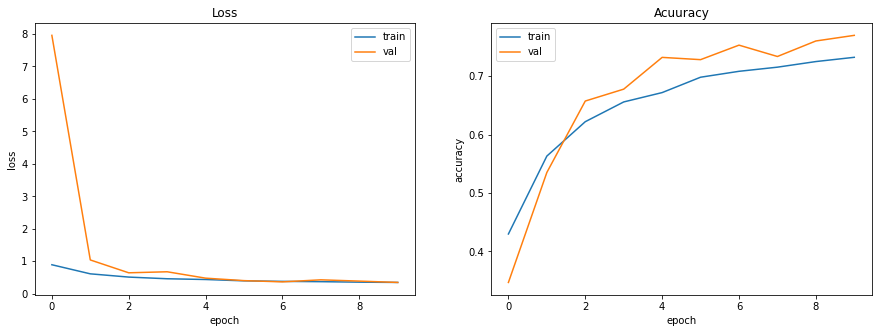

In [11]:
import matplotlib.pyplot as plt
history = hist.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Acuuracy')

plt.show()